# NRFA DATA ANALYSIS

## 0 Introduction

<p style="line-height: 1.75;">
In this baseline, I mainly focus on analysing the spatiotemporal patterns of four selected stations shown below: 1 in By Brook river (Middlehill), and 3 in Avon river (St James, Bathford, Bath Ultrasonic). </br>
The flow and rainfall datasets are downloaded and the relationships might exist in each station based on its flow and rainfall volume, or, there will probably be relationships across different stations which have geographical combination. </br>
Datasets are from website National River Flow Arhive (NRFA) and UK Centre for Ecology & Hydrology. 

<img src="../prior_images/station_map.png" width=1000px height=400px />

## 1 Import and Load Datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import math
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import ccf, adfuller
from statsmodels.tsa.api import VAR
from tslearn.metrics import cdist_dtw
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import linkage, dendrogram

import warnings
warnings.filterwarnings("ignore")

/opt/miniconda3/envs/conv-seq/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
## 1) Load flow datasets of each station
Bath_St_James_flow = pd.read_csv('Dataset_NRFA/Avon@Bath_St_James/53003_gdf.csv').iloc[18:, :2].reset_index(drop=True)
Bathford_flow = pd.read_csv('Dataset_NRFA/Avon@Bathford/53018_gdf_live.csv').iloc[18:, :2].reset_index(drop=True)
Bath_Ultrasonic_flow = pd.read_csv('Dataset_NRFA/Avon@Bath_Ultrasonic/53022_gdf.csv').iloc[19:, :2].reset_index(drop=True)
Middlehill_flow = pd.read_csv('Dataset_NRFA/ByBrook@Middlehill/53028_gdf.csv').iloc[19:, :2].reset_index(drop=True)

Bath_St_James_flow.columns = ['Date', 'Flow']
Bathford_flow.columns = ['Date', 'Flow']
Bath_Ultrasonic_flow.columns = ['Date', 'Flow']
Middlehill_flow.columns = ['Date', 'Flow']

Bath_St_James_flow['Date'] = pd.to_datetime(Bath_St_James_flow['Date']).sort_values().reset_index(drop=True)
Bathford_flow['Date'] = pd.to_datetime(Bathford_flow['Date']).sort_values().reset_index(drop=True)
Bath_Ultrasonic_flow['Date'] = pd.to_datetime(Bath_Ultrasonic_flow['Date']).sort_values().reset_index(drop=True)
Middlehill_flow['Date'] = pd.to_datetime(Middlehill_flow['Date']).sort_values().reset_index(drop=True)

print("Flow datasets loaded successfully.\n")
print("Flow in Bath St James station: starts from", Bath_St_James_flow['Date'][0], "to", Bath_St_James_flow['Date'].iloc[-1], ", total", len(Bath_St_James_flow), "records.")
print("Flow in Bathford station: starts from", Bathford_flow['Date'][0], "to", Bathford_flow['Date'].iloc[-1], ", total", len(Bathford_flow), "records.")
print("Flow in Bath Ultrasonic station: starts from", Bath_Ultrasonic_flow['Date'][0], "to", Bath_Ultrasonic_flow['Date'].iloc[-1], ", total", len(Bath_Ultrasonic_flow), "records.")
print("Flow in Middlehill station: starts from", Middlehill_flow['Date'][0], "to", Middlehill_flow['Date'].iloc[-1], ", total", len(Middlehill_flow), "records.")

Flow datasets loaded successfully.

Flow in Bath St James station: starts from 1939-12-01 00:00:00 to 1969-09-30 00:00:00 , total 10897 records.
Flow in Bathford station: starts from 1969-11-14 00:00:00 to 2025-10-12 00:00:00 , total 20422 records.
Flow in Bath Ultrasonic station: starts from 1976-09-01 00:00:00 to 2024-09-22 00:00:00 , total 17554 records.
Flow in Middlehill station: starts from 1982-01-01 00:00:00 to 2024-09-30 00:00:00 , total 15614 records.


In [3]:
## 2) Load rainfall datasets of each station
Bath_St_James_rainfall = pd.read_csv('Dataset_NRFA/Avon@Bath_St_James/53003_cdr.csv').iloc[18:, :2].reset_index(drop=True)
Bathford_rainfall = pd.read_csv('Dataset_NRFA/Avon@Bathford/53018_cdr.csv').iloc[19:, :2].reset_index(drop=True)
Bath_Ultrasonic_rainfall = pd.read_csv('Dataset_NRFA/Avon@Bath_Ultrasonic/53022_cdr.csv').iloc[19:, :2].reset_index(drop=True)
Middlehill_rainfall = pd.read_csv('Dataset_NRFA/ByBrook@Middlehill/53028_cdr.csv').iloc[19:, :2].reset_index(drop=True)

Bath_St_James_rainfall.columns = ['Date', 'Rainfall']
Bathford_rainfall.columns = ['Date', 'Rainfall']
Bath_Ultrasonic_rainfall.columns = ['Date', 'Rainfall']
Middlehill_rainfall.columns = ['Date', 'Rainfall']

Bath_St_James_rainfall['Date'] = pd.to_datetime(Bath_St_James_rainfall['Date']).sort_values().reset_index(drop=True)
Bathford_rainfall['Date'] = pd.to_datetime(Bathford_rainfall['Date']).sort_values().reset_index(drop=True)
Bath_Ultrasonic_rainfall['Date'] = pd.to_datetime(Bath_Ultrasonic_rainfall['Date']).sort_values().reset_index(drop=True)
Middlehill_rainfall['Date'] = pd.to_datetime(Middlehill_rainfall['Date']).sort_values().reset_index(drop=True)

print("Rainfall datasets loaded successfully.\n")
print("Rainfall in Bath St James station: starts from", Bath_St_James_rainfall['Date'][0], "to", Bath_St_James_rainfall['Date'].iloc[-1], ", total", len(Bath_St_James_rainfall), "records.")
print("Rainfall in Bathford station: starts from", Bathford_rainfall['Date'][0], "to", Bathford_rainfall['Date'].iloc[-1], ", total", len(Bathford_rainfall), "records.")
print("Rainfall in Bath Ultrasonic station: starts from", Bath_Ultrasonic_rainfall['Date'][0], "to", Bath_Ultrasonic_rainfall['Date'].iloc[-1], ", total", len(Bath_Ultrasonic_rainfall), "records.")
print("Rainfall in Middlehill station: starts from", Middlehill_rainfall['Date'][0], "to", Middlehill_rainfall['Date'].iloc[-1], ", total", len(Middlehill_rainfall), "records.")

Rainfall datasets loaded successfully.

Rainfall in Bath St James station: starts from 1939-01-01 00:00:00 to 2023-12-31 00:00:00 , total 31046 records.
Rainfall in Bathford station: starts from 1961-01-01 00:00:00 to 2023-12-31 00:00:00 , total 23010 records.
Rainfall in Bath Ultrasonic station: starts from 1961-01-01 00:00:00 to 2023-12-31 00:00:00 , total 23010 records.
Rainfall in Middlehill station: starts from 1961-01-01 00:00:00 to 2023-12-31 00:00:00 , total 23010 records.


In [4]:
## 3) Merge flow and rainfall datasets based on Date
Bath_St_James_data = pd.merge(Bath_St_James_flow, Bath_St_James_rainfall, on='Date')
Bathford_data = pd.merge(Bathford_flow, Bathford_rainfall, on='Date')
Bath_Ultrasonic_data = pd.merge(Bath_Ultrasonic_flow, Bath_Ultrasonic_rainfall, on='Date')
Middlehill_data = pd.merge(Middlehill_flow, Middlehill_rainfall, on='Date')
print("Merged flow and rainfall datasets successfully.\n")

## 4) Handle missing values by filling with 0
Bath_St_James_data = Bath_St_James_data.fillna(0)
Bathford_data = Bathford_data.fillna(0)
Bath_Ultrasonic_data = Bath_Ultrasonic_data.fillna(0)
Middlehill_data = Middlehill_data.fillna(0)
print("Filled missing values with 0 successfully.\n")

## 5) Transform numerical columns to float type
Bath_St_James_data['Flow'] = Bath_St_James_data['Flow'].astype(float)
Bath_St_James_data['Rainfall'] = Bath_St_James_data['Rainfall'].astype(float)
Bathford_data['Flow'] = Bathford_data['Flow'].astype(float)
Bathford_data['Rainfall'] = Bathford_data['Rainfall'].astype(float)
Bath_Ultrasonic_data['Flow'] = Bath_Ultrasonic_data['Flow'].astype(float)
Bath_Ultrasonic_data['Rainfall'] = Bath_Ultrasonic_data['Rainfall'].astype(float)
Middlehill_data['Flow'] = Middlehill_data['Flow'].astype(float)
Middlehill_data['Rainfall'] = Middlehill_data['Rainfall'].astype(float)
print("Transformed numerical columns to float type successfully.\n")

Merged flow and rainfall datasets successfully.

Filled missing values with 0 successfully.

Transformed numerical columns to float type successfully.



In [5]:
## 6) Set up some variables for later analysis
stations = {
    'Bath St James': Bath_St_James_data,
    'Bathford': Bathford_data,
    'East Twerton': Bath_Ultrasonic_data,
    'Middlehill': Middlehill_data
}
station_names = list(stations.keys())
num_stations = len(station_names)
print("Prepared data for", num_stations, "stations:", station_names, "\n")

Prepared data for 4 stations: ['Bath St James', 'Bathford', 'East Twerton', 'Middlehill'] 



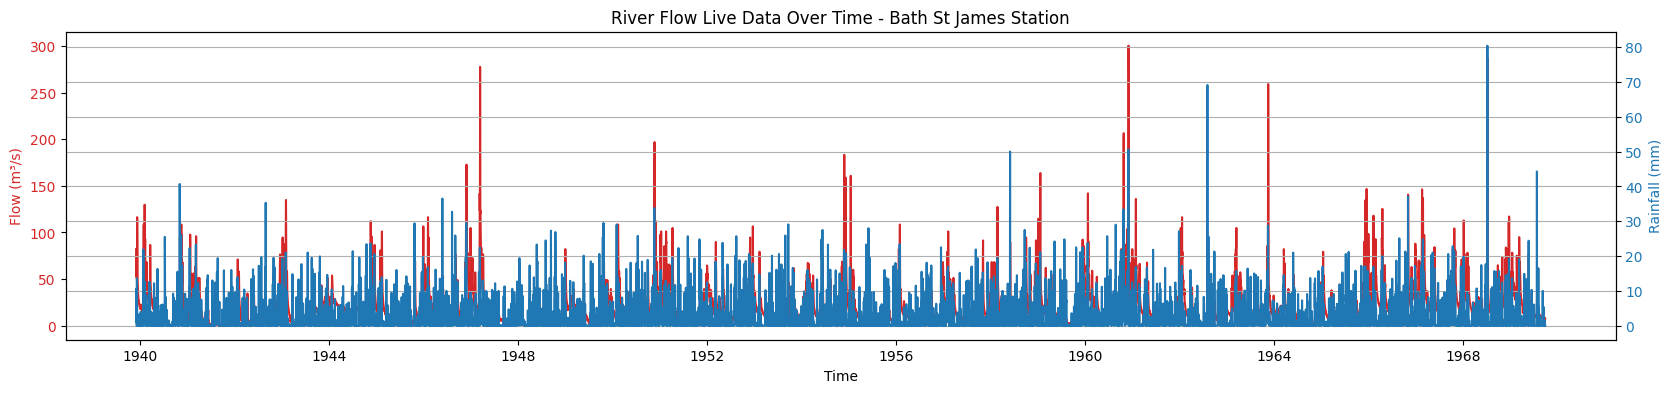

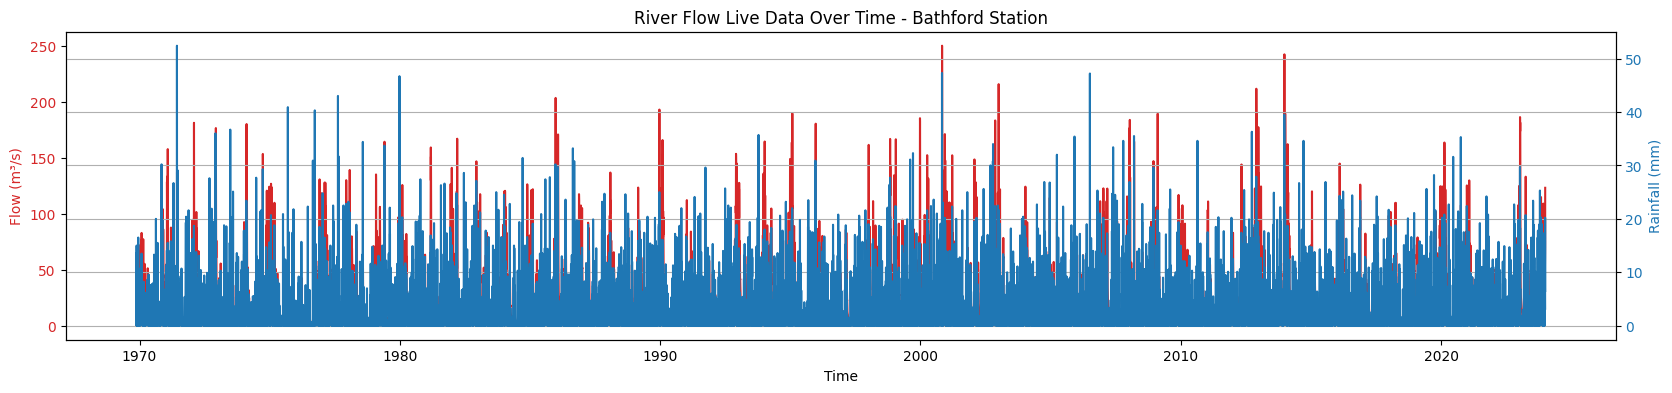

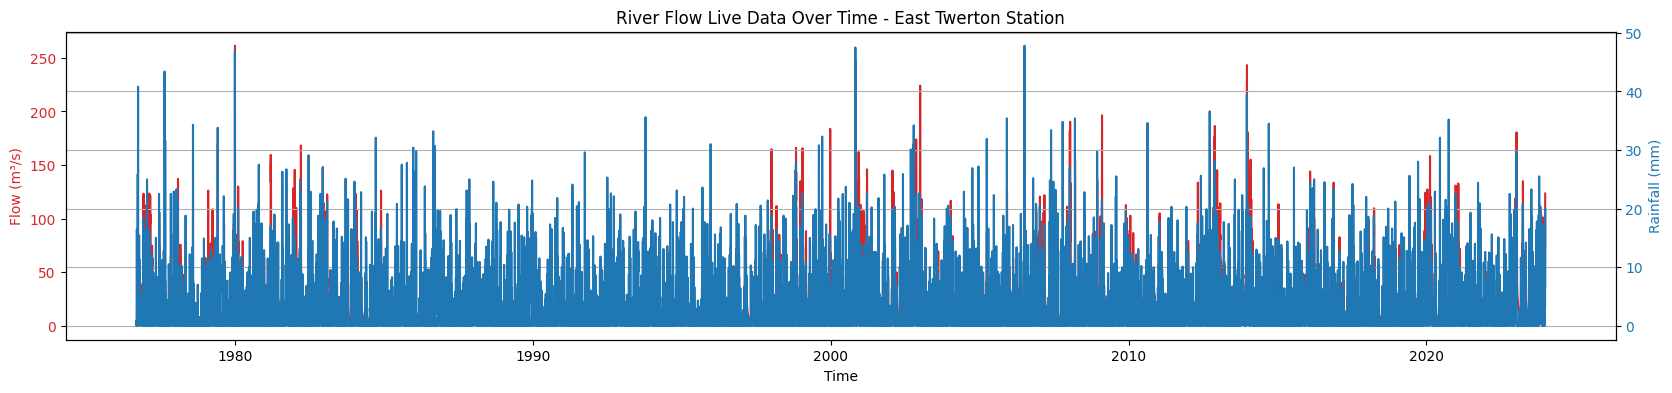

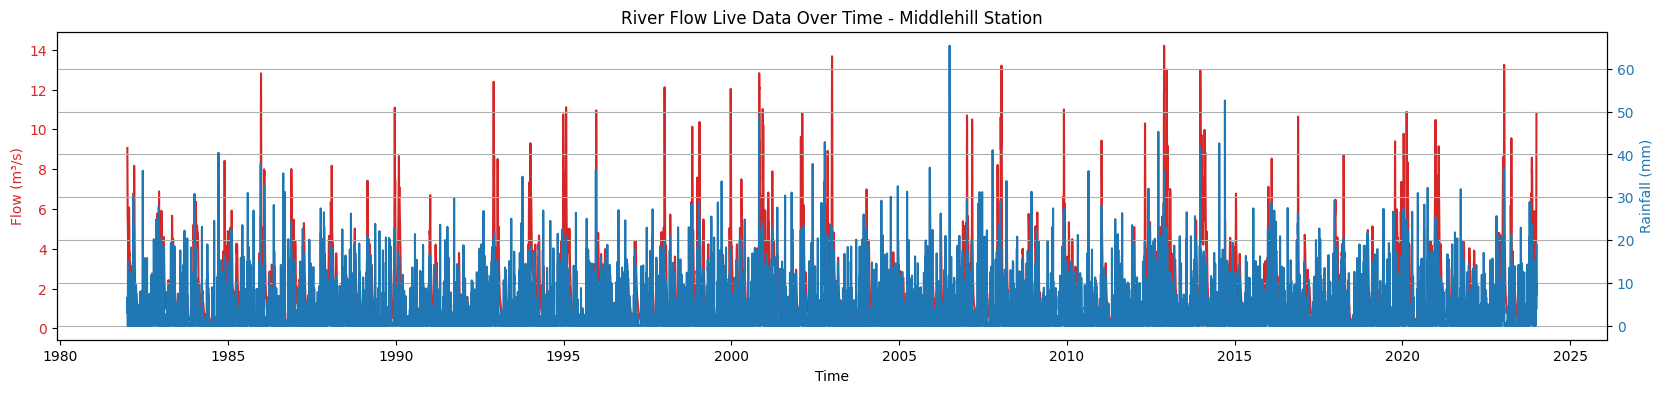

In [6]:
## 7) Visualise flow and rainfall data over time
for i in range(num_stations):
    station_name = station_names[i]
    df = stations[station_name]
    # plt.figure(figsize=(20, 4))
    fig, ax1 = plt.subplots()

    ax1.figure.set_size_inches(20, 4)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Flow (m³/s)', color='tab:red')
    ax1.plot(list(df['Date']), list(df['Flow']), color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Rainfall (mm)', color='tab:blue')
    ax2.plot(list(df['Date']), list(df['Rainfall']), color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    plt.title(f'River Flow Live Data Over Time - {station_name} Station')
    # fig.tight_layout()
    plt.grid()
    plt.show()

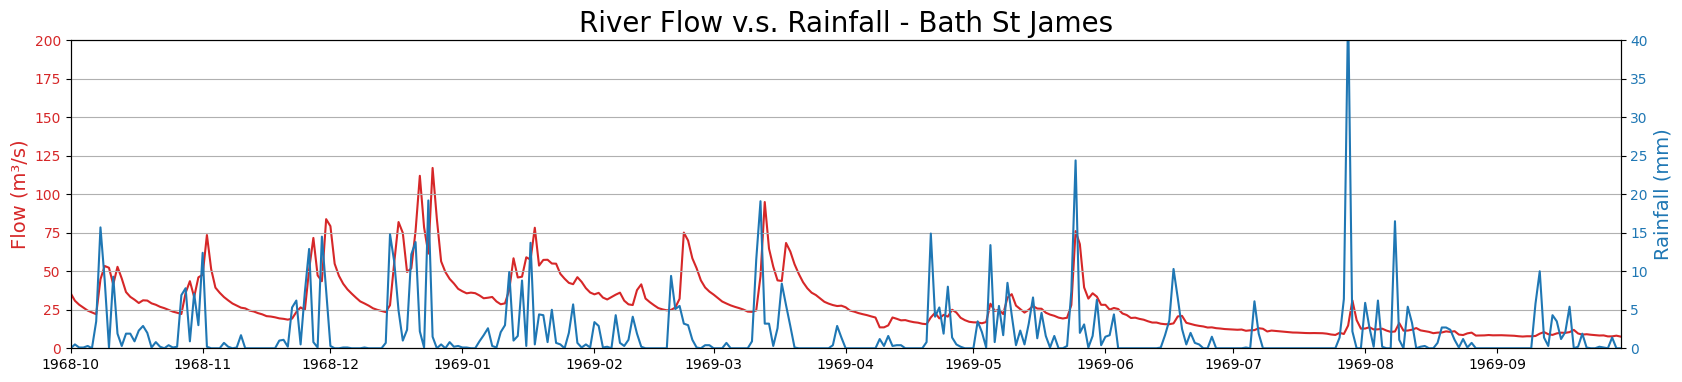

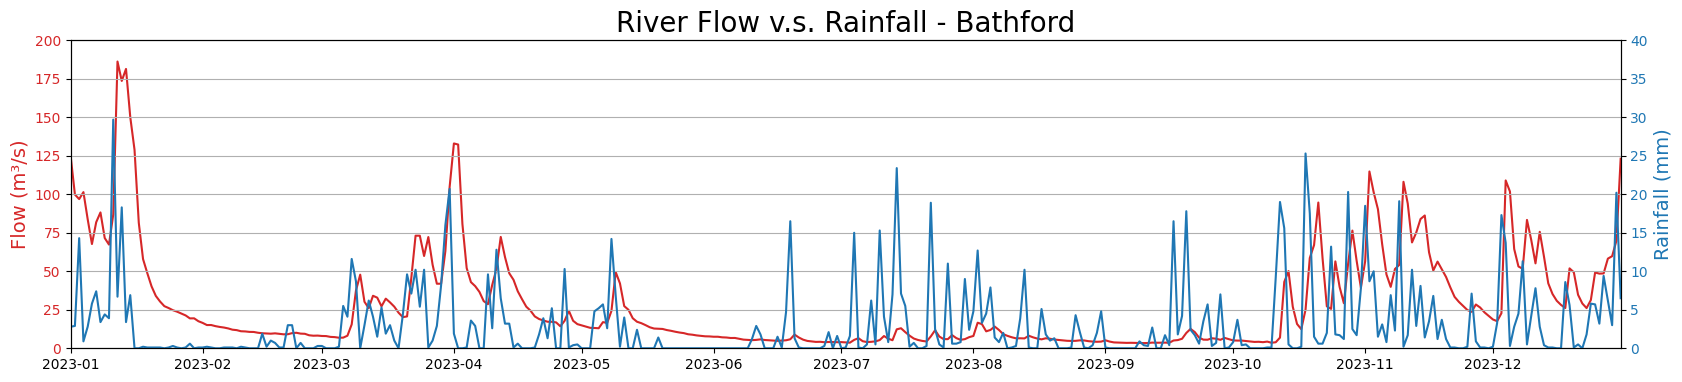

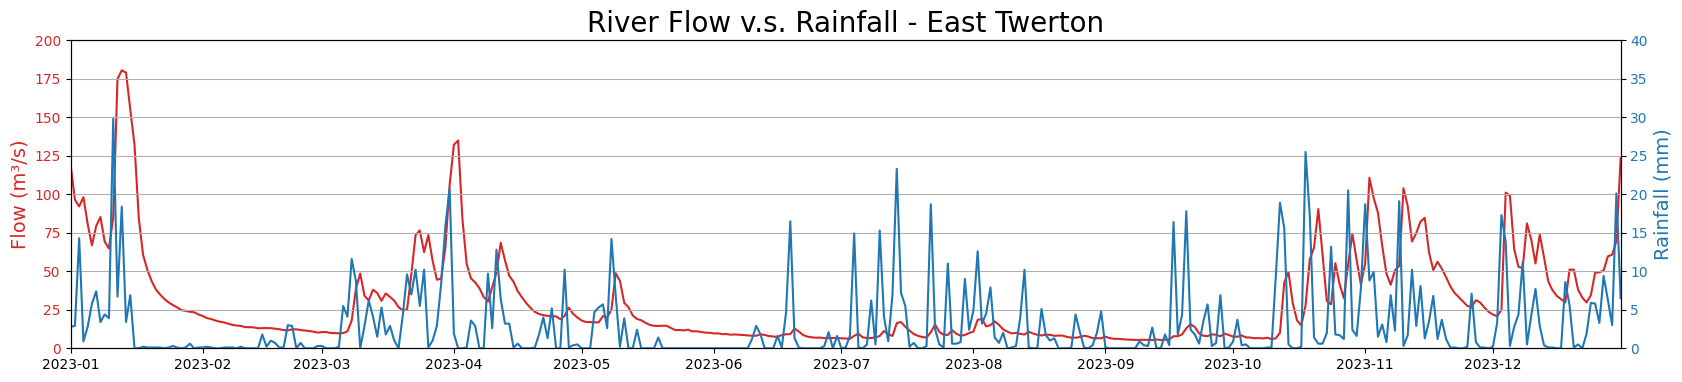

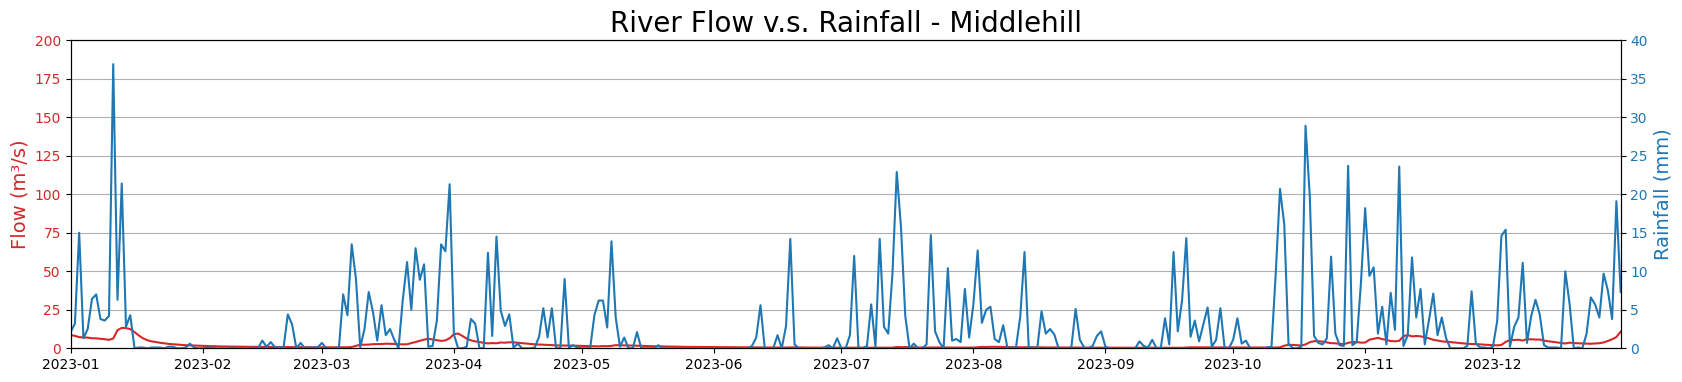

In [7]:
## 8) zoom in to see recent data
for i in range(num_stations):
    station_name = station_names[i]
    df = stations[station_name]
    # plt.figure(figsize=(20, 4))
    fig, ax1 = plt.subplots()

    ax1.figure.set_size_inches(20, 4)
    # ax1.set_xlabel('Time')
    ax1.set_ylabel('Flow (m³/s)', color='tab:red', fontsize=14)
    ax1.plot(list(df['Date']), list(df['Flow']), color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.set_ylim([0, 200])

    ax2 = ax1.twinx()
    ax2.set_ylabel('Rainfall (mm)', color='tab:blue', fontsize=14)
    ax2.plot(list(df['Date']), list(df['Rainfall']), color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylim([0, 40])

    ax1.set_xlim([df['Date'].iloc[-365], df['Date'].iloc[-1]])
    ax2.set_xlim([df['Date'].iloc[-365], df['Date'].iloc[-1]])
    plt.title(f'River Flow v.s. Rainfall - {station_name}', fontsize=20)
    # fig.tight_layout()
    plt.grid()
    plt.savefig(f'NRFA_outputs/River_Flow_Rainfall_{station_name}.png')
    plt.show()

## 2 Basic Calculation and Peak Detection

In [9]:
## Caluculate the rainfall to flow ratio for each station
for i in range(num_stations):
    station_name = station_names[i]
    df = stations[station_name]
    total_rainfall = df['Rainfall'].sum()
    total_flow = df['Flow'].sum()
    if total_rainfall == 0:
        ratio = float('inf')
    else:
        ratio = total_flow / total_rainfall
    print(f'Total Rainfall in {station_name} Station: {total_rainfall:.2f} mm')
    print(f'Total Flow in {station_name} Station: {total_flow:.2f} m³/s')
    print(f'Rainfall to Flow Ratio in {station_name} Station: {ratio:.4f} m³/s per mm\n')

Total Rainfall in Bath St James Station: 24736.70 mm
Total Flow in Bath St James Station: 209286.92 m³/s
Rainfall to Flow Ratio in Bath St James Station: 8.4606 m³/s per mm

Total Rainfall in Bathford Station: 46149.40 mm
Total Flow in Bathford Station: 390488.66 m³/s
Rainfall to Flow Ratio in Bathford Station: 8.4614 m³/s per mm

Total Rainfall in East Twerton Station: 41120.70 mm
Total Flow in East Twerton Station: 262151.35 m³/s
Rainfall to Flow Ratio in East Twerton Station: 6.3752 m³/s per mm

Total Rainfall in Middlehill Station: 38231.30 mm
Total Flow in Middlehill Station: 25019.63 m³/s
Rainfall to Flow Ratio in Middlehill Station: 0.6544 m³/s per mm



In [10]:
## A function to calculate the every local peaks of flow and rainfall for each station
from scipy.signal import find_peaks
def calculate_peaks(df, threshold=0.9): 
    flow_peaks, _ = find_peaks(df['Flow'], height=df['Flow'].quantile(threshold))
    rainfall_peaks, _ = find_peaks(df['Rainfall'], height=df['Rainfall'].quantile(threshold))

    flow_peak_values = df['Flow'].iloc[flow_peaks].values
    rainfall_peak_values = df['Rainfall'].iloc[rainfall_peaks].values

    return flow_peaks, flow_peak_values, rainfall_peaks, rainfall_peak_values

<Figure size 2000x400 with 0 Axes>

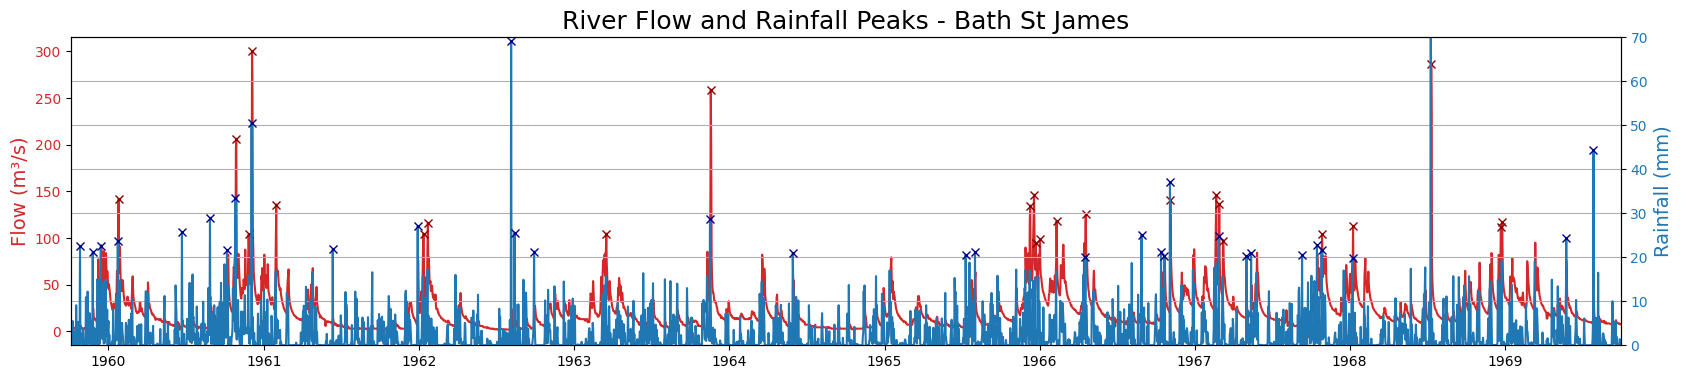

<Figure size 2000x400 with 0 Axes>

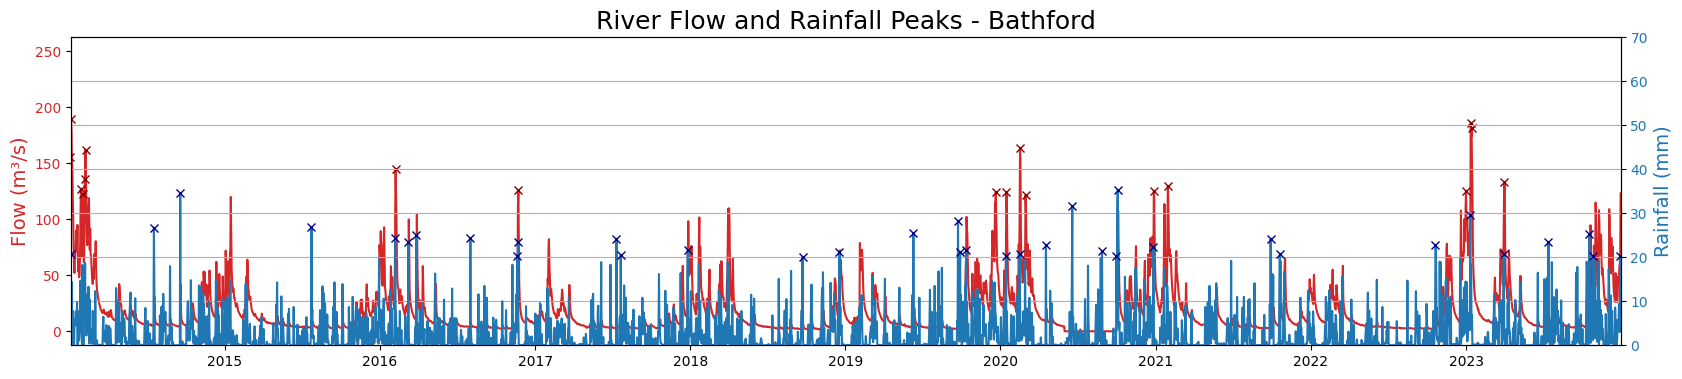

<Figure size 2000x400 with 0 Axes>

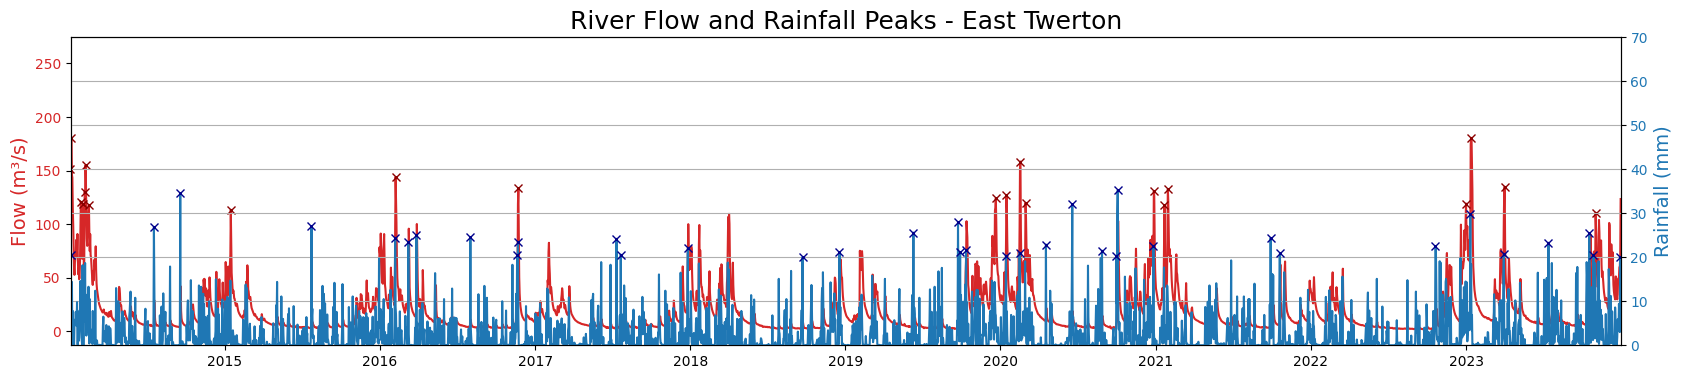

<Figure size 2000x400 with 0 Axes>

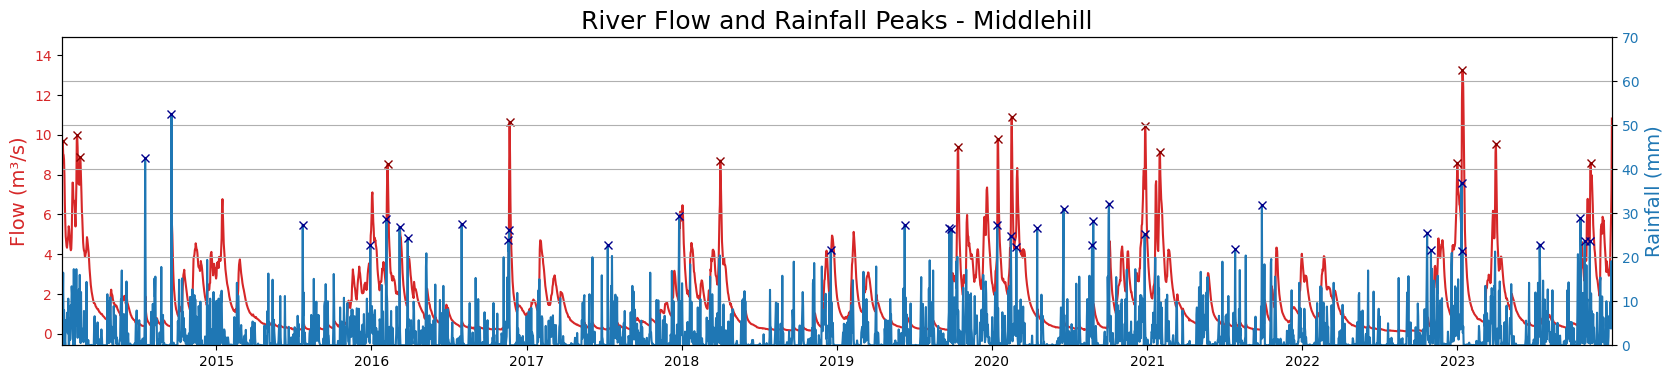

In [11]:
## calculate and plot the peaks for each station
for i in range(num_stations):
    station_name = station_names[i]
    df = stations[station_name]
    flow_peaks, flow_peak_values, rainfall_peaks, rainfall_peak_values = calculate_peaks(df, threshold=0.99)

    plt.figure(figsize=(20, 4))
    fig, ax1 = plt.subplots()

    ax1.figure.set_size_inches(20, 4)
    # ax1.set_xlabel('Time')
    ax1.set_ylabel('Flow (m³/s)', color='tab:red', fontsize=14)
    ax1.plot(list(df['Date']), list(df['Flow']), color='tab:red')
    ax1.plot(df['Date'].iloc[flow_peaks], flow_peak_values, "x", color='darkred', label='Flow Peaks')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Rainfall (mm)', color='tab:blue', fontsize=14)
    ax2.plot(list(df['Date']), list(df['Rainfall']), color='tab:blue')
    ax2.plot(df['Date'].iloc[rainfall_peaks], rainfall_peak_values, "x", color='darkblue', label='Rainfall Peaks')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # ax1.set_ylim([0, 260])
    ax2.set_ylim([0, 70])
    ax1.set_xlim([df['Date'].iloc[-365*10], df['Date'].iloc[-1]])
    ax2.set_xlim([df['Date'].iloc[-365*10], df['Date'].iloc[-1]])
    plt.title(f'River Flow and Rainfall Peaks - {station_name}', fontsize=18)
    plt.grid()
    plt.savefig(f'NRFA_outputs/flow_rainfall_peak_{station_name}.png')
    plt.show()

## 3 Correlation Analysis of Each Stations

In [12]:
## The stationary statistics for each station
print("Augmented Dickey-Fuller Test Results: (if p-value < 0.05, then it is stationary.)")
for i in range(num_stations):
    station_name = station_names[i]
    df = stations[station_name]
    df_diff = df.diff().dropna()
    p_val_flow = adfuller(df_diff['Flow'])[1]
    p_val_rainfall = adfuller(df_diff['Rainfall'])[1]
    print(f"ADF p-value for {station_name}: {p_val_flow:.4f}, {p_val_rainfall:.4f}")

Augmented Dickey-Fuller Test Results: (if p-value < 0.05, then it is stationary.)
ADF p-value for Bath St James: 0.0000, 0.0000
ADF p-value for Bathford: 0.0000, 0.0000
ADF p-value for East Twerton: 0.0000, 0.0000
ADF p-value for Middlehill: 0.0000, 0.0000


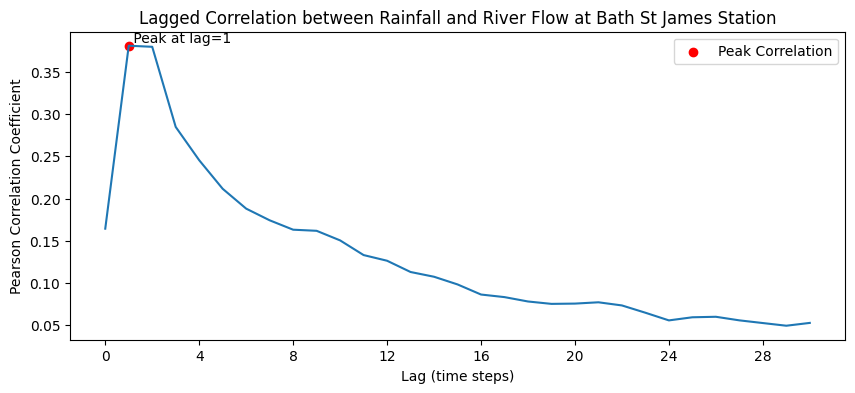

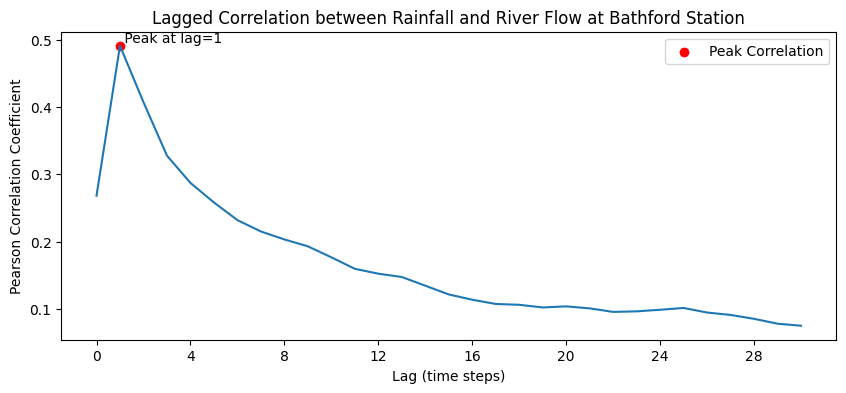

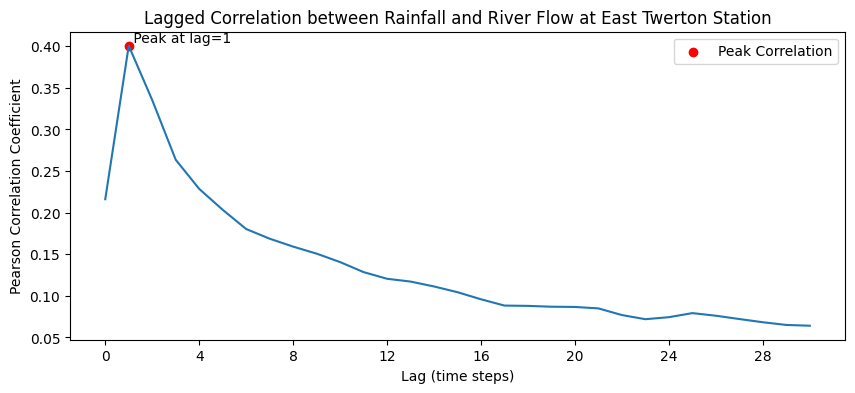

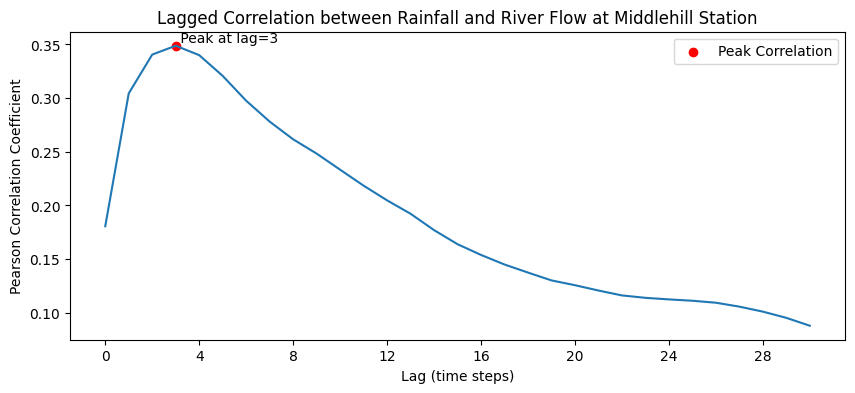

In [13]:
## Calculate the lagged correlation between flow peaks and rainfall peaks for each station
for i in range(num_stations):
    station_name = station_names[i]
    df = stations[station_name]
    # calculate lagged correlation
    max_lag = 30  # Max lag of 30 days
    lagged_correlations = []
    for lag in range(max_lag + 1):
        shifted_rain = df['Rainfall'].shift(lag)
        valid_indices = shifted_rain.dropna().index # df[['Flow', 'Rainfall']].dropna().index
        corr_coef, p_value = pearsonr(df.loc[valid_indices, 'Flow'], shifted_rain.loc[valid_indices])
        lagged_correlations.append(corr_coef)
        # print(f"Lag {lag}: Correlation = {corr_coef:.3f}, p-value = {p_value:.3f}")
    plt.figure(figsize=(10, 4))
    plt.plot(range(max_lag + 1), lagged_correlations)
    plt.xticks(range(0, max_lag + 1, 4))
    plt.scatter(np.where(np.array(lagged_correlations) == max(lagged_correlations))[0], 
                [max(lagged_correlations)], color='red', label='Peak Correlation')
    plt.text(np.where(np.array(lagged_correlations) == max(lagged_correlations))[0][0], 
             max(lagged_correlations), 
             f' Peak at lag={np.where(np.array(lagged_correlations) == max(lagged_correlations))[0][0]}',
             fontsize=10, verticalalignment='bottom', horizontalalignment='left')
    plt.legend()
    plt.title(f'Lagged Correlation between Rainfall and River Flow at {station_name} Station')
    plt.xlabel('Lag (time steps)')
    plt.ylabel('Pearson Correlation Coefficient')
    plt.show()

By season. 

In [14]:
def trans_to_season_map(df):

    df['Month'] = df['Date'].dt.month
    season_name_map = {
        1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Autumn', 10: 'Autumn', 11: 'Autumn',
        12: 'Winter'
    }
    
    df['Season'] = df['Month'].map(season_name_map)
    
    season_num_map = {
        1: 4, 2: 4,  # Winter
        3: 1, 4: 1, 5: 1,  # Spring
        6: 2, 7: 2, 8: 2,  # Summer
        9: 3, 10: 3, 11: 3, # Autumn
        12: 4         # Winter
    }
    df['Season_Num'] = df['Month'].map(season_num_map)
    
    return df.dropna(how='all')

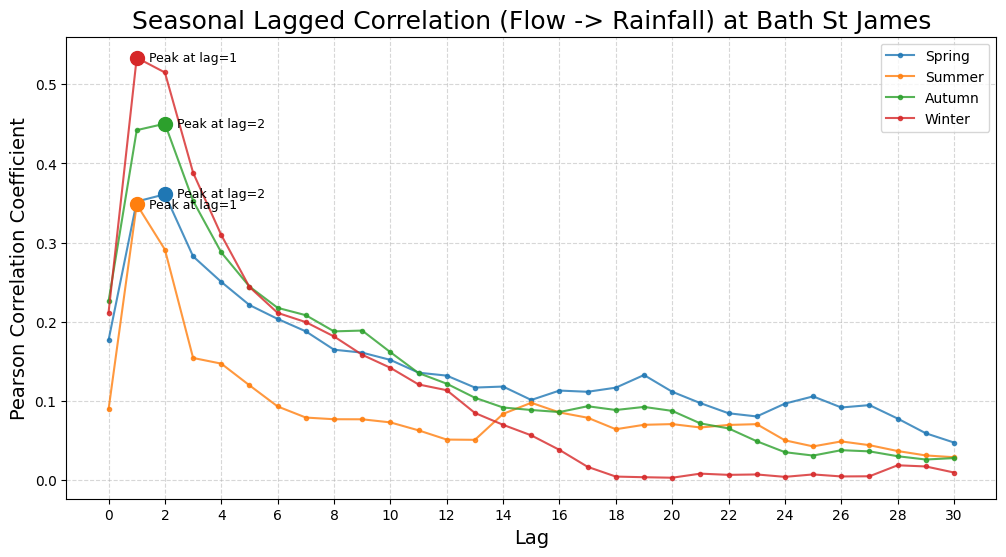

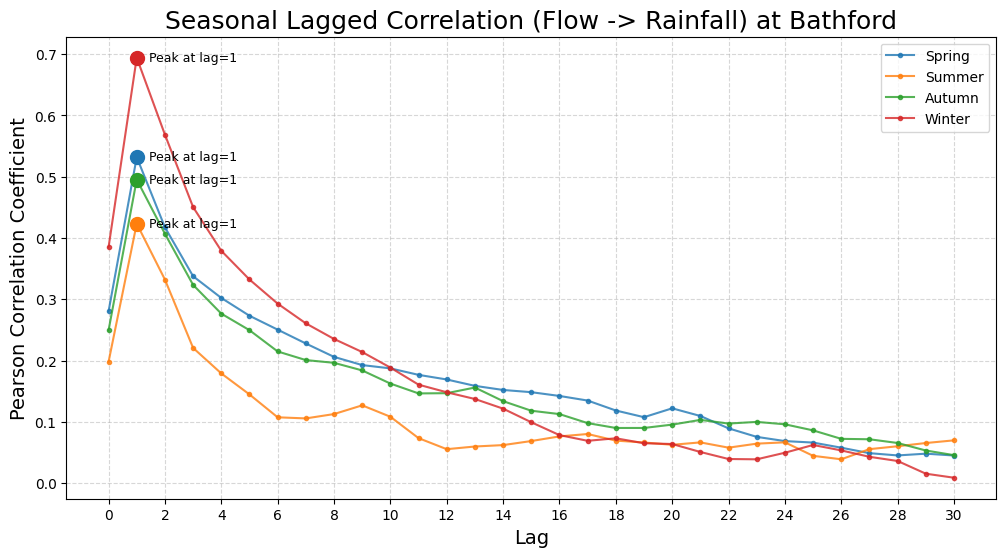

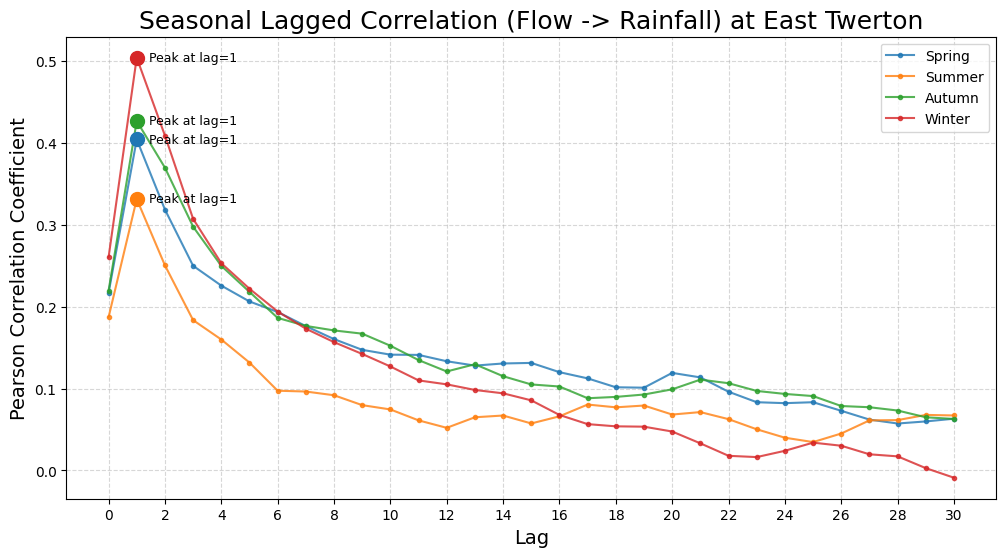

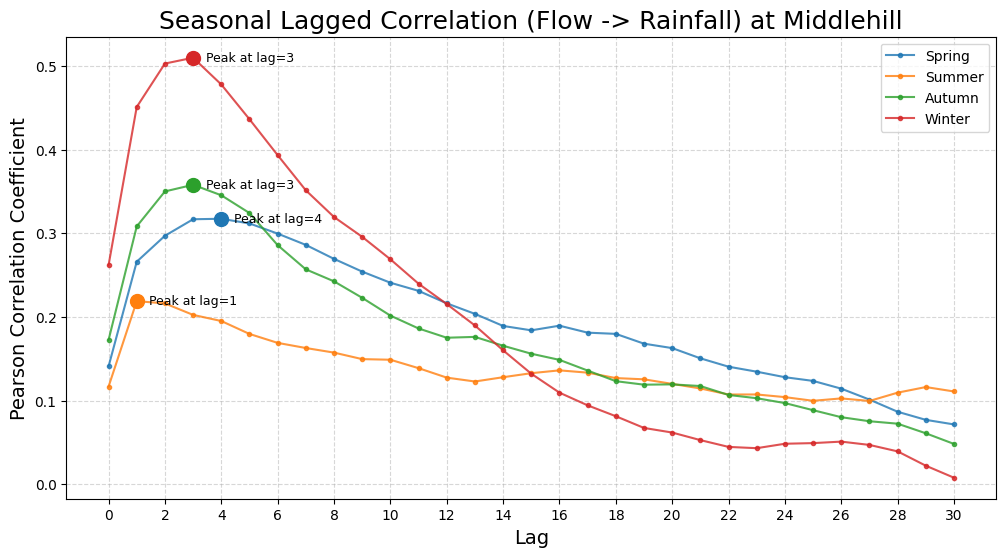

In [17]:
for i in range(num_stations):
    station_name = station_names[i]
    df_original = trans_to_season_map(stations[station_name].copy()) 

    max_lag = 30  # Max lag of 30d 
    seasons = ['Spring', 'Summer', 'Autumn', 'Winter']

    lagged_corr_by_season = {season: [] for season in seasons}

    for season in seasons:
        df_season = df_original[df_original['Season'] == season]
        
        for lag in range(max_lag + 1):
            shifted_level = df_season['Rainfall'].shift(lag)

            valid_indices = shifted_level.dropna().index

            flow_data = df_season.loc[valid_indices, 'Flow']
            level_data = shifted_level.loc[valid_indices]

            if len(flow_data) < 2: 
                corr_coef = np.nan
            else:
                corr_coef, p_value = pearsonr(flow_data, level_data)
                
            lagged_corr_by_season[season].append(corr_coef)

    plt.figure(figsize=(12, 6))
    
    for season in seasons:
        correlations = lagged_corr_by_season[season]

        if all(np.isnan(correlations)):
            print(f"Skipped: there is no effective relevant data at {station_name} in {season}.")
            continue
            
        plt.plot(range(max_lag + 1), correlations, label=f'{season}', marker='.', alpha=0.8)
        
        peak_corr = np.nanmax(correlations)
        peak_lag_idx = np.nanargmax(correlations)
        
        plt.scatter(peak_lag_idx, peak_corr, s=100, zorder=5)
        plt.text(peak_lag_idx + 0.3, peak_corr, 
                 f' Peak at lag={peak_lag_idx}', 
                 fontsize=9, verticalalignment='center')

    plt.title(f'Seasonal Lagged Correlation (Flow -> Rainfall) at {station_name}', fontsize=18)
    plt.xlabel('Lag', fontsize=14)
    plt.ylabel('Pearson Correlation Coefficient', fontsize=14)
    plt.xticks(range(0, max_lag + 1, 2))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.savefig(f'NRFA_outputs/PCC_rainfall_{station_name}.png')
    plt.show()

In [14]:
## Align the dataframe based on the date
DF = pd.merge(Bathford_data, Bath_Ultrasonic_data, on='Date', suffixes=('_Bathford', '_Bath_Ultrasonic'))
DF = pd.merge(DF, Middlehill_data, on='Date', suffixes=('_Bath_Ultrasonic', '_Middlehill'))
DF = DF[['Date', 'Flow_Bathford', 'Rainfall_Bathford', 'Flow_Bath_Ultrasonic', 'Rainfall_Bath_Ultrasonic', 'Flow', 'Rainfall']]
DF.rename(columns={'Flow': 'Flow_Middlehill', 'Rainfall': 'Rainfall_Middlehill'}, inplace=True)
print("Aligned dataframe based on date successfully.\n")
DF

Aligned dataframe based on date successfully.



,Date,Flow_Bathford,Rainfall_Bathford,Flow_Bath_Ultrasonic,Rainfall_Bath_Ultrasonic,Flow_Middlehill,Rainfall_Middlehill
0,1982-01-01,80.19,4.2,80.99,4.2,9.060,3.1
1,1982-01-02,77.72,2.1,80.15,2.2,7.481,3.8
2,1982-01-03,67.11,2.3,68.26,2.3,6.229,3.6
3,1982-01-04,59.13,4.3,57.21,4.3,5.682,6.7
4,1982-01-05,65.26,2.8,63.13,2.8,5.562,2.0
...,...,...,...,...,...,...,...
15335,2023-12-27,48.60,9.4,50.49,9.4,3.799,9.7
15336,2023-12-28,58.21,6.2,59.71,6.3,4.746,7.5
15337,2023-12-29,59.81,3.0,60.76,3.0,5.816,3.8
15338,2023-12-30,69.80,20.2,69.60,20.1,7.276,19.1


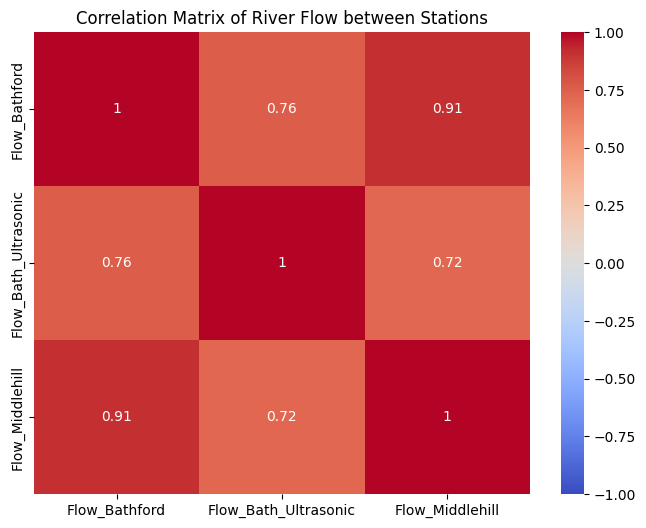

In [15]:
## Correlation of Flow-Flow between stations
station_flow_columns = ['Flow_Bathford', 'Flow_Bath_Ultrasonic', 'Flow_Middlehill']
flow_corr_matrix = DF[station_flow_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(flow_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of River Flow between Stations')
plt.show()

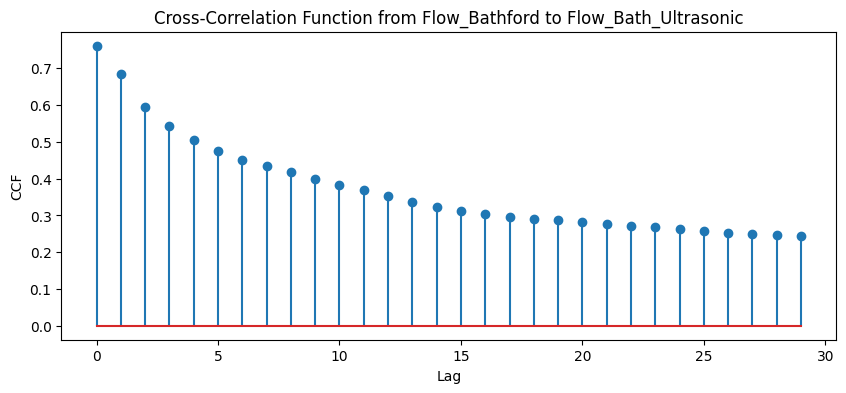

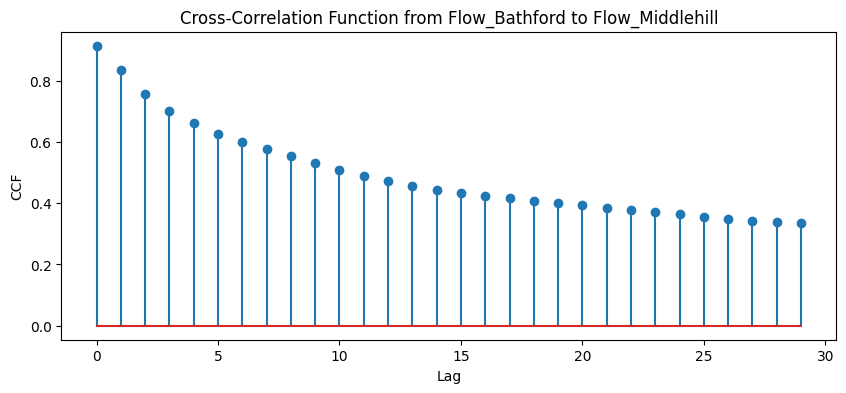

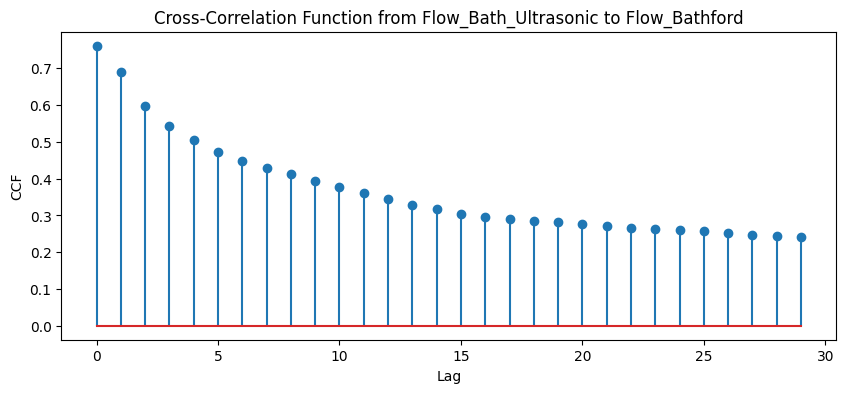

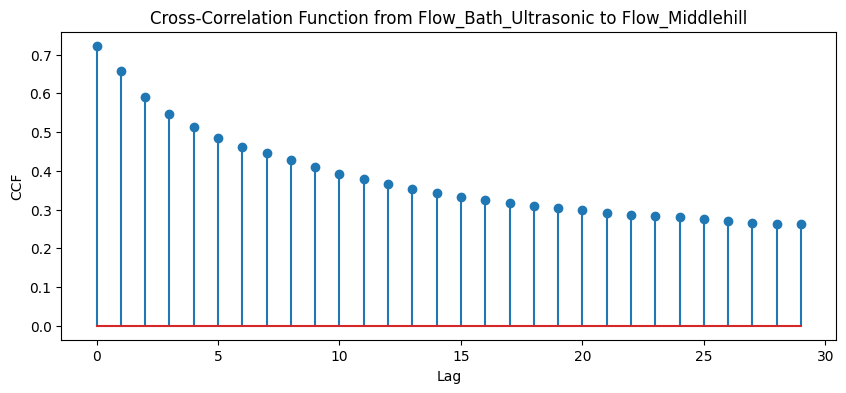

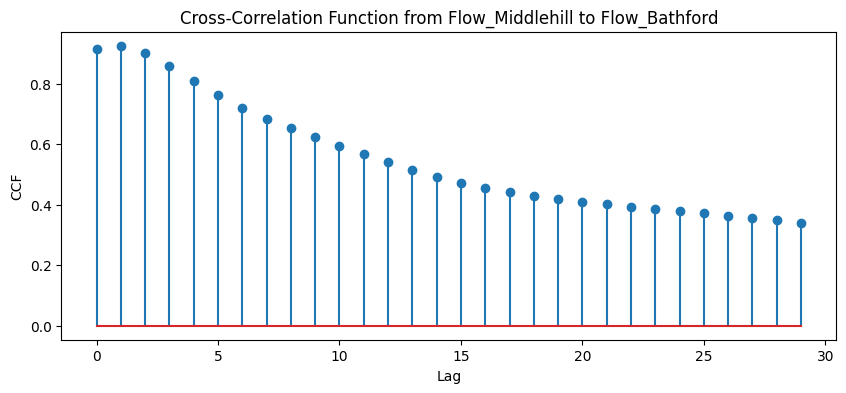

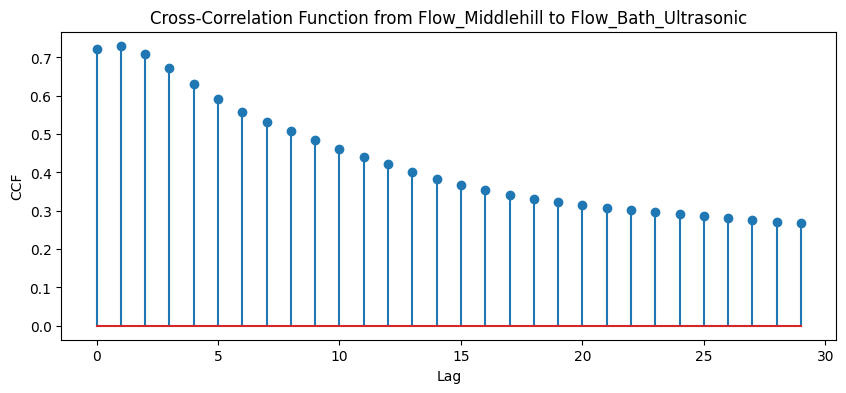

In [16]:
## CCF between Flow series of each stations
for i in station_flow_columns:
    for j in station_flow_columns:
        if i != j:
            ccf_values = ccf(DF[i], DF[j])[:30]
            plt.figure(figsize=(10, 4))
            plt.stem(range(len(ccf_values)), ccf_values, use_line_collection=True)
            plt.title(f'Cross-Correlation Function from {i} to {j}')
            plt.xlabel('Lag')
            plt.ylabel('CCF')
            plt.show()

Middlehill is the upstream. 

In [17]:
## Granger Causality Test between stations
max_lag = 30
station_flow_columns = ['Flow_Bathford', 'Flow_Bath_Ultrasonic', 'Flow_Middlehill']
station_rainfall_columns = ['Rainfall_Bathford', 'Rainfall_Bath_Ultrasonic', 'Rainfall_Middlehill']
df_granger = DF.diff().dropna()

endog_data = df_granger[station_flow_columns]
exog_data = df_granger[station_rainfall_columns]

# VAR-X model fitting
model = VAR(endog=endog_data, exog=exog_data)
results = model.fit(max_lag)
print(results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 10, Nov, 2025
Time:                     10:45:30
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    4.49818
Nobs:                     15309.0    HQIC:                   4.40414
Log likelihood:          -98240.2    FPE:                    78.0630
AIC:                      4.35752    Det(Omega_mle):         76.6425
--------------------------------------------------------------------
Results for equation Flow_Bathford
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            0.004539         0.080324            0.057           0.955
Rainfall_Bathford              -10.152686         1.556254           -6.524           0.000
Rainfall

In [18]:
print("Granger Causality Test Results (p-values):")
print("Null Hypothesis (H0): 'Cause' DOES NOT Granger-cause 'Effect'")
print("If p-value < 0.05, we REJECT H0 (i.e., it *does* cause it)\n")

graph = {}
for cause in station_flow_columns:
    for effect in station_flow_columns:
        if cause == effect:
            continue
        
        # check whether 'cause' is G-causes 'effect'
        test_result = results.test_causality(effect, [cause], kind='f')
        p_value = test_result.pvalue
        
        if p_value < 0.05:
            print(f"** {cause} -> {effect} ** (p-value: {p_value:.4f})  [STATISTICALLY SIGNIFICANT]")
            if effect not in graph:
                graph[effect] = []
            graph[effect].append(cause)
        else:
            # print(f"{cause} -x-> {effect} (p-value: {p_value:.4f})")
            pass

print("\n--- Inferred Graph (A -> B means A G-causes B) ---")
print(graph)

Granger Causality Test Results (p-values):
Null Hypothesis (H0): 'Cause' DOES NOT Granger-cause 'Effect'
If p-value < 0.05, we REJECT H0 (i.e., it *does* cause it)

** Flow_Bathford -> Flow_Bath_Ultrasonic ** (p-value: 0.0000)  [STATISTICALLY SIGNIFICANT]
** Flow_Bathford -> Flow_Middlehill ** (p-value: 0.0000)  [STATISTICALLY SIGNIFICANT]
** Flow_Bath_Ultrasonic -> Flow_Bathford ** (p-value: 0.0027)  [STATISTICALLY SIGNIFICANT]
** Flow_Middlehill -> Flow_Bathford ** (p-value: 0.0000)  [STATISTICALLY SIGNIFICANT]
** Flow_Middlehill -> Flow_Bath_Ultrasonic ** (p-value: 0.0000)  [STATISTICALLY SIGNIFICANT]

--- Inferred Graph (A -> B means A G-causes B) ---
{'Flow_Bath_Ultrasonic': ['Flow_Bathford', 'Flow_Middlehill'], 'Flow_Middlehill': ['Flow_Bathford'], 'Flow_Bathford': ['Flow_Bath_Ultrasonic', 'Flow_Middlehill']}


Data shape for tslearn: (3, 15340, 1)
DTW Pairwise Distance Matrix:
                      Flow_Bathford  Flow_Bath_Ultrasonic  Flow_Middlehill
Flow_Bathford              0.000000              3.949843         3.858999
Flow_Bath_Ultrasonic       3.949843              0.000000         4.896340
Flow_Middlehill            3.858999              4.896340         0.000000


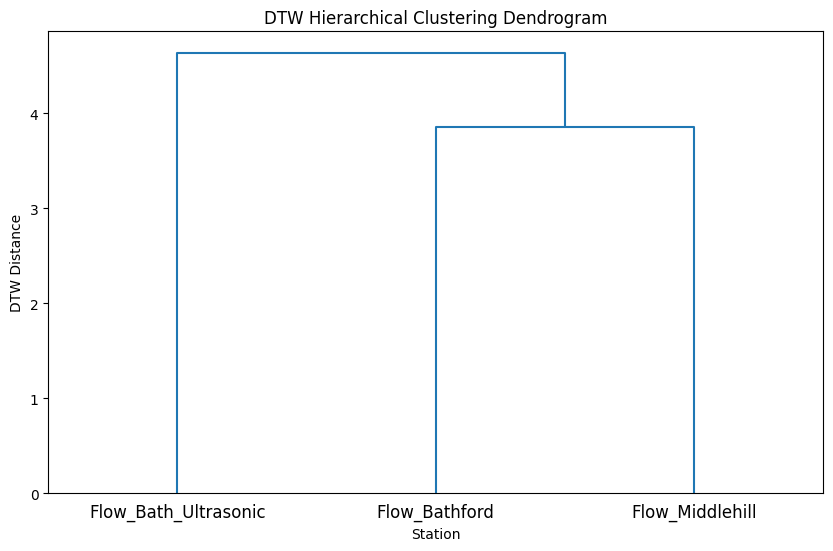

In [19]:
# Dynamic Time Warping (DTW) Clustering
# DTW is used for comparing the similarity of the "shape" of sequences. 

# Normalisation
scaler = MinMaxScaler()
df_dtw = DF[station_flow_columns].copy()
df_dtw_scaled = scaler.fit_transform(df_dtw)
time_series = df_dtw_scaled.T
time_series_tsl = time_series.reshape(time_series.shape[0], time_series.shape[1], 1)

print(f"Data shape for tslearn: {time_series_tsl.shape}")

# 2. Calculate 4x4 DTW distance matrix
dist_matrix = cdist_dtw(time_series_tsl)

print("DTW Pairwise Distance Matrix:")
print(pd.DataFrame(dist_matrix, index=station_flow_columns, columns=station_flow_columns))

# 3. hierarchical clustering
condensed_dist = dist_matrix[np.triu_indices(len(station_flow_columns), k=1)]
Z = linkage(condensed_dist, method='ward')

# 4. Draw Dendrogram
plt.figure(figsize=(10, 6))
plt.title('DTW Hierarchical Clustering Dendrogram')
plt.xlabel('Station')
plt.ylabel('DTW Distance')
dendrogram(
    Z,
    labels=station_flow_columns,
    leaf_rotation=0.,
    leaf_font_size=12.,
)
plt.show()